###  f = u' + u

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.net(x)

# Instantiate model and optimizer
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Collocation points for physics loss (PDE)
x_collocation = torch.linspace(0, 1, 100).reshape(-1, 1)
x_collocation.requires_grad = True

# Generate some noisy data points 
torch.manual_seed(0)
x_data = torch.linspace(0, 1, 10).view(-1, 1)
u_true = torch.exp(-x_data)
noise = 0.05 * torch.randn_like(u_true)
u_data = u_true + noise  # noisy observations

physics_losses = []
data_losses = []
ic_losses = []
total_losses = []
# Training loop
num_epochs = 3000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Predict u at collocation points
    u_pred = model(x_collocation)
    # u'(x) -autograd
    u_x = torch.autograd.grad(u_pred, x_collocation, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    # f = u' + u
    f = u_x + u_pred

    # Physics loss
    physics_loss = torch.mean(f**2)

    # Data loss: MSE between model prediction and noisy data
    u_data_pred = model(x_data)
    data_loss = torch.mean((u_data_pred - u_data)**2)

    # Initial condition loss: u(0) = 1
    u0_pred = model(torch.zeros(1, 1))
    ic_loss = (u0_pred - 1)**2

    # Total loss
    loss = physics_loss + data_loss + ic_loss

    loss.backward()
    optimizer.step()

    physics_losses.append(physics_loss.item())
    data_losses.append(data_loss.item())
    ic_losses.append(ic_loss.item())
    total_losses.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, Data Loss: {data_loss.item():.6f}, IC Loss: {ic_loss.item():.6f}")

# Test prediction at x=0.5
with torch.no_grad():
    x_test = torch.tensor([[0.5]])
    u_test_pred = model(x_test).item()
    u_test_true = torch.exp(torch.tensor(-0.5)).item()
    print(f"\nPrediction at x=0.5: {u_test_pred:.4f}")
    print(f"True value at x=0.5: {u_test_true:.4f}")


Epoch 0, Loss: 1.133916, Physics Loss: 0.033484, Data Loss: 0.363285, IC Loss: 0.737147
Epoch 500, Loss: 0.003204, Physics Loss: 0.000257, Data Loss: 0.002923, IC Loss: 0.000024
Epoch 1000, Loss: 0.003035, Physics Loss: 0.000123, Data Loss: 0.002894, IC Loss: 0.000017
Epoch 1500, Loss: 0.003005, Physics Loss: 0.000092, Data Loss: 0.002897, IC Loss: 0.000017
Epoch 2000, Loss: 0.002987, Physics Loss: 0.000069, Data Loss: 0.002901, IC Loss: 0.000016
Epoch 2500, Loss: 0.002977, Physics Loss: 0.000056, Data Loss: 0.002905, IC Loss: 0.000016

Prediction at x=0.5: 0.6010
True value at x=0.5: 0.6065


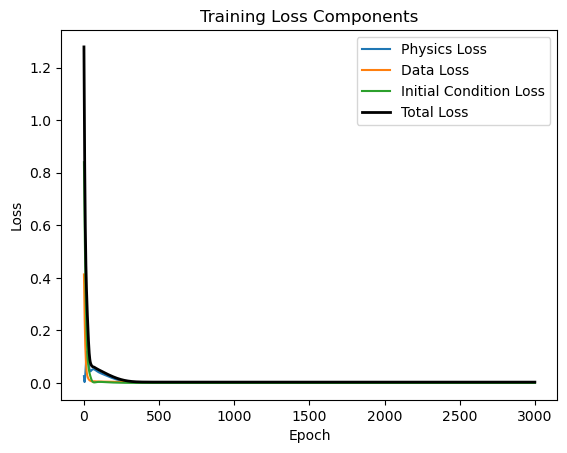

In [6]:
import matplotlib.pyplot as plt

plt.plot(physics_losses, label='Physics Loss')
plt.plot(data_losses, label='Data Loss')
plt.plot(ic_losses, label='Initial Condition Loss')
plt.plot(total_losses, label='Total Loss', linewidth=2, color='black')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Components')
plt.legend()
plt.show()